# Author: Warren Lee

In [5]:
# Import libraries
import numpy as np
import pandas as pd
import math

# Import Daily Turnstile Data from Repo

In [6]:
turnstiles_daily = pd.read_csv("turnstiles_daily.csv")

turnstiles_daily.head()

,C/A,UNIT,SCP,LINENAME,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
0,A002,R051,02-00-00,NQR456W,59 ST,01/12/2020,7341214,01/11/2020,7340476.0,738.0
1,A002,R051,02-00-00,NQR456W,59 ST,01/13/2020,7342558,01/12/2020,7341214.0,181.0
2,A002,R051,02-00-00,NQR456W,59 ST,01/14/2020,7343865,01/13/2020,7342558.0,181.0
3,A002,R051,02-00-00,NQR456W,59 ST,01/15/2020,7345249,01/14/2020,7343865.0,181.0
4,A002,R051,02-00-00,NQR456W,59 ST,01/16/2020,7346629,01/15/2020,7345249.0,181.0


# Process Station ID Data

In [15]:
# source: https://qri.cloud/nyc-transit-data/remote_complex_lookup
# taking the Complex ID and Remote Unit variable to map onto turnstile data using the UNIT variable.

station_ids = pd.read_csv("station_ids.csv")

station_ids.columns = ['UNIT','C/A','ID','STATION','LINENAME','DIVISION']

# here, ID refers to the complex of a metro station - some complexes might include multiple stops
station_ids=station_ids[['UNIT','ID']]
station_ids = station_ids.drop_duplicates()
station_ids.sample(n=5)

,UNIT,ID
473,R267,270.0
123,R055,447.0
187,R100,108.0
142,R067,350.0
524,R299,286.0


# Process Station Location Data

Source: http://web.mta.info/developers/data/nyct/subway/Stations.csv

In [17]:
location_raw = pd.read_csv("Stations.csv")

columns = ['Complex ID','Stop Name','Borough','GTFS Latitude','GTFS Longitude']
col_names = ['ID','STATION_L','BOROUGH','LAT','LON']
naming = {columns[i]:col_names[i] for i in range(len(columns))}

location_raw = location_raw.rename(columns=naming) 

# Note that there are multiple coordinates for a given stop ID
id_freq = location_raw.groupby(['ID'])['LAT'].count().reset_index().sort_values('LAT',ascending=False)
print("id_freq has",len(id_freq[id_freq['LAT']>1]),"IDs with multiple latitudes")

id_freq[id_freq['LAT']>1].head()

id_freq has 35 IDs with multiple latitudes


,ID,LAT
423,611,5
440,628,4
436,624,4
435,623,4
413,601,3


#### Look into ID 611 (Times Sq), note that coordinates vary slightly based on location of line for each station

In [18]:
location_raw[location_raw['ID']==611]

,Station ID,ID,GTFS Stop ID,Division,Line,STATION_L,BOROUGH,Daytime Routes,Structure,LAT,LON,North Direction Label,South Direction Label,ADA,ADA Notes
10,11,611,R16,BMT,Broadway - Brighton,Times Sq-42 St,M,N Q R W,Subway,40.754672,-73.986754,Uptown & Queens,Downtown & Brooklyn,1,NaN
162,163,611,A27,IND,8th Av - Fulton St,42 St-Port Authority Bus Terminal,M,A C E,Subway,40.757308,-73.989735,Uptown - Queens,Downtown & Brooklyn,1,NaN
317,317,611,127,IRT,Broadway - 7Av,Times Sq-42 St,M,1 2 3,Subway,40.755290,-73.987495,Uptown & The Bronx,Downtown & Brooklyn,1,NaN
468,467,611,725,IRT,Flushing,Times Sq-42 St,M,7,Subway,40.755477,-73.987691,Queens,34 St - Hudson Yards,1,NaN
469,468,611,902,IRT,Lexington - Shuttle,Times Sq-42 St,M,S,Subway,40.755983,-73.986229,NaN,Grand Central,0,NaN


#### Resolve to average latitude and longitude of IDs to capture general location of IDs

In [21]:
location = location_raw.groupby(['ID','BOROUGH'])[['LAT','LON']].mean()
location.head()

,,LAT,LON
ID,BOROUGH,,
1,Q,40.775036,-73.912034
2,Q,40.770258,-73.917843
3,Q,40.766779,-73.921479
4,Q,40.761820,-73.925508
5,Q,40.756804,-73.929575


# Process Income Data

#### NY household income data from
https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2018-zip-code-data-soi
#### import (takes a while)

In [22]:
zip_income_raw = pd.read_excel("18zp33ny.xlsx",skiprows =3,usecols="A:C",nrows=10745)
zip_income_raw.columns = ['ZIP','INCGROUP','NRETURNS']
zip_income_raw.head()

,ZIP,INCGROUP,NRETURNS
0,NaN,NaN,NaN
1,NaN,NaN,-1.0
2,0.0,Total,9632130.0
3,0.0,"$1 under $25,000",3161790.0
4,0.0,"$25,000 under $50,000",2223030.0


In [24]:
# drop the NAs
zip_income = zip_income_raw.copy().dropna(subset=['ZIP'])

#flag total groups
zip_income.loc[zip_income['INCGROUP'].isna(),'INCGROUP'] = "Total" 
zip_income['FLAG_TOTAL'] = 0
zip_income.loc[zip_income['INCGROUP']=='Total','FLAG_TOTAL'] = 1

#flag rich groups
zip_income['FLAG_RICH'] = 0
zip_income.loc[zip_income['INCGROUP']=='$200,000 or more','FLAG_RICH'] = 1 

# keep only highest tier and total counts
zip_income = zip_income[(zip_income['FLAG_RICH']==1) | (zip_income['FLAG_TOTAL']==1)]
zip_income = zip_income.groupby(['ZIP','INCGROUP']).NRETURNS.sum()
zip_income

ZIP      INCGROUP        
0.0      $200,000 or more     634070.0
         Total               9632130.0
10001.0  $200,000 or more       3170.0
         Total                 16150.0
10002.0  $200,000 or more       2210.0
                               ...    
14482.0  Total                  4080.0
14485.0  $200,000 or more         50.0
         Total                  2010.0
14486.0  $200,000 or more          0.0
         Total                   160.0
Name: NRETURNS, Length: 2686, dtype: float64

In [25]:
rich_zips = zip_income.unstack('INCGROUP').reset_index()
rich_zips['RICH_INDEX'] = rich_zips['$200,000 or more']/rich_zips['Total']

rich_zips.head()

INCGROUP,ZIP,"$200,000 or more",Total,RICH_INDEX
0,0.0,634070.0,9632130.0,0.065829
1,10001.0,3170.0,16150.0,0.196285
2,10002.0,2210.0,42400.0,0.052123
3,10003.0,7240.0,29270.0,0.247352
4,10004.0,920.0,2470.0,0.372470


# Merge zip code to location data

In [26]:
zipcodes = pd.read_csv("us-zip-code-latitude-and-longitude.csv",delimiter=";")

# keep only NYC zipcodes
zipcodes = zipcodes[(zipcodes['State']=="NY")&(zipcodes['City']=="New York")]

columns = ['Zip','Latitude','Longitude']
col_names = ['ZIP','LAT','LON']
naming = {columns[i]:col_names[i] for i in range(len(columns))}

zipcodes = zipcodes.rename(columns=naming)
zipcodes

,ZIP,City,State,LAT,LON,Timezone,Daylight savings time flag,geopoint
229,10117,New York,NY,40.780751,-73.977182,-5,1,"40.780751,-73.977182"
627,10242,New York,NY,40.780751,-73.977182,-5,1,"40.780751,-73.977182"
774,10125,New York,NY,40.780751,-73.977182,-5,1,"40.780751,-73.977182"
1128,10034,New York,NY,40.867653,-73.920000,-5,1,"40.867653,-73.92"
1129,10038,New York,NY,40.709677,-74.003650,-5,1,"40.709677,-74.00365"
...,...,...,...,...,...,...,...,...
41841,10122,New York,NY,40.751757,-73.992171,-5,1,"40.751757,-73.992171"
42015,10114,New York,NY,40.780751,-73.977182,-5,1,"40.780751,-73.977182"
42024,10131,New York,NY,40.780751,-73.977182,-5,1,"40.780751,-73.977182"
42202,10011,New York,NY,40.741012,-74.000120,-5,1,"40.741012,-74.00012"


#### Find the shortest distance between station coordinates and zipcode coordinates to determine zipcode of a station

We note that use of this method may mean that stations could be mislabeled with zip codes if the station is on the border of a zip code's area and ends up being closer to an outside zip code as opposed to it's local zip code

In [27]:
zips = []
for idx, row in location.iterrows():
    lat = row['LAT']
    lon = row ['LON']
    
    min_dist = float('inf')
    min_zip = None
    
    for idx_2, row_2 in zipcodes.iterrows():
        lat_2 = row_2['LAT']
        lon_2= row_2['LON']
        
        norm = (lat-lat_2)**2 + (lon-lon_2)**2
        norm = math.sqrt(norm)
        if norm<min_dist:
            min_dist = norm
            min_zip = row_2['ZIP']
    
    zips.append([min_zip,min_dist])

zips[:5]

[[10035, 0.03483067637873825],
 [10162, 0.03110072901074764],
 [10162, 0.027569646823997627],
 [10044, 0.02366464789512149],
 [10044, 0.020317502922354562]]

#### Merging data to location data frame

In [28]:
location['ZIP'] = pd.DataFrame([x[0] for x in zips]).set_index(location.index)
location

,,LAT,LON,ZIP
ID,BOROUGH,,,
1,Q,40.775036,-73.912034,10035
2,Q,40.770258,-73.917843,10162
3,Q,40.766779,-73.921479,10162
4,Q,40.761820,-73.925508,10044
5,Q,40.756804,-73.929575,10044
...,...,...,...,...
628,M,40.710089,-74.007838,10045
629,Bk,40.713428,-73.950847,10009
630,Bk,40.699622,-73.911986,10009


# Merge income information to location data

In [43]:
location_inc = location.reset_index().merge(rich_zips,on="ZIP",how='left',indicator=True).drop(columns=['$200,000 or more','Total'])
# print merge results
print(len(location_inc[location_inc['_merge']=='both']),"obs merged out of",len(location_inc))

location_inc = location_inc.drop(columns='_merge')

location_inc.sample(n=5)

# note: resolve to fill missing income data with values predicted using
# a regression on available values? Can use geographic coordinates to 
# predict rich-index assuming income levels are dependent on location.
# See appendix

196 obs merged out of 445


,ID,BOROUGH,LAT,LON,ZIP,RICH_INDEX
24,37,Bk,40.629742,-74.025510,11286,NaN
253,307,M,40.807722,-73.964110,10115,NaN
167,208,Q,40.600066,-73.761353,11302,NaN
323,386,Bx,40.844434,-73.914685,10040,0.023202
268,325,M,40.722854,-74.006277,10013,0.274382


# Merge ID with Stations

In [31]:
merge_id = turnstiles_daily.merge(station_ids,on=['UNIT'],how='left',indicator=True)

# print merge results
print(len(merge_id[merge_id['_merge']=='both']),"obs merged out of",len(merge_id))

# drop indicator
merge_id = merge_id.drop(columns='_merge')

# determine percentage of ridership captured by ID'd stations
id_ridership = merge_id[~merge_id['ID'].isna()].DAILY_ENTRIES.sum()
total_ridership = merge_id.DAILY_ENTRIES.sum()
print("The ridership captured by stations with IDs is", id_ridership/total_ridership)

merge_id.sample(n=10)

202826 obs merged out of 202826
The ridership captured by stations with IDs is 0.9496226013666643


,C/A,UNIT,SCP,LINENAME,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES,ID
50984,N057,R188,00-03-02,CE,50 ST,04/09/2020,11731011,04/08/2020,11730925.0,86.0,162.0
76708,N303,R015,00-00-09,EM,5 AV/53 ST,05/25/2020,1071149,05/24/2020,1071145.0,4.0,276.0
32216,H007,R248,00-03-02,L,1 AV,06/01/2020,6632477,05/31/2020,6632477.0,0.0,119.0
18400,B025,R150,00-00-02,BQ,AVENUE U,04/06/2020,1737101,04/05/2020,1736938.0,163.0,52.0
85286,N333A,R141,00-03-01,EFMR,FOREST HILLS 71,06/04/2020,4241480,06/03/2020,4240707.0,773.0,261.0
95523,N502,R021,01-00-02,BDFM7,42 ST-BRYANT PK,06/05/2020,849337,06/04/2020,849221.0,116.0,609.0
110652,N700,R570,00-00-02,Q,72 ST-2 AVE,01/16/2020,1574728,01/15/2020,1572697.0,181.0,477.0
165008,R260,R205,01-06-01,245,149/GRAND CONC,01/13/2020,451971,01/12/2020,450993.0,181.0,439.0
75891,N225,R157,01-00-02,D,NORWOOD 205 ST,05/28/2020,134529054,05/27/2020,134528863.0,191.0,210.0
182618,R514,R094,00-05-00,NQW,ASTORIA BLVD,01/14/2020,12,01/13/2020,12.0,0.0,2.0


In [32]:
# list of stations with no ID - can confirm with source document that no ID exists for these stations

pd.Series(merge_id[merge_id['ID'].isna()]['STATION'].unique()).sort_values()

10        14TH STREET
9          9TH STREET
8      CHRISTOPHER ST
7          CITY / BUS
5      EXCHANGE PLACE
4        GROVE STREET
2            HARRISON
3      JOURNAL SQUARE
13         LACKAWANNA
15       NEWARK BM BW
16           NEWARK C
17       NEWARK HM HE
1     NEWARK HW BMEBE
0       ORCHARD BEACH
19       PATH NEW WTC
18         PATH WTC 2
6     PAVONIA/NEWPORT
20      RIT-MANHATTAN
21      RIT-ROOSEVELT
12          THIRTY ST
14    THIRTY THIRD ST
11    TWENTY THIRD ST
dtype: object

# Merge location and income on ID

In [45]:
merge_loc = merge_id.merge(location_inc,on=['ID'],how='left',indicator=True)

# print merge results
print(len(merge_loc[merge_loc['_merge']=='both']),"obs merged out of",len(merge_loc))

# drop indicator
merge_loc = merge_loc.drop(columns='_merge')

merge_loc.sample(n=15)

188768 obs merged out of 202826


,C/A,UNIT,SCP,LINENAME,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES,ID,BOROUGH,LAT,LON,ZIP,RICH_INDEX
199070,R641,R210,00-00-01,25,BEVERLY RD,02/03/2020,9716478,02/02/2020,9715150.0,181.0,357.0,Bk,40.645098,-73.948959,11517.0,NaN
74487,N217,R112,00-03-00,BD,FORDHAM RD,04/06/2020,26240,04/05/2020,26118.0,122.0,213.0,Bx,40.861296,-73.897749,10034.0,0.020613
147542,R201,R041,00-00-02,45,BOWLING GREEN,04/07/2020,2084270,04/06/2020,2084238.0,32.0,414.0,M,40.704817,-74.014065,10006.0,0.266932
199540,R645,R110,00-00-00,25,FLATBUSH AV-B.C,03/15/2020,165900,03/14/2020,165301.0,599.0,359.0,Bk,40.632836,-73.947642,11517.0,NaN
182298,R514,R094,00-00-00,NQW,ASTORIA BLVD,02/05/2020,6497962,02/04/2020,6497792.0,170.0,2.0,Q,40.770258,-73.917843,10162.0,0.452055
65401,N120,R153,00-05-01,AC,UTICA AV,02/05/2020,2,02/04/2020,2.0,0.0,181.0,Bk,40.679364,-73.930729,11517.0,NaN
50164,N051,R084,02-00-03,ABCD1,59 ST COLUMBUS,04/09/2020,787519,04/08/2020,787374.0,145.0,614.0,M,40.768271,-73.981832,10107.0,NaN
93505,N420B,R317,00-06-00,G,CLINTON-WASH AV,05/27/2020,388274,05/26/2020,388175.0,99.0,291.0,Bk,40.688089,-73.966839,11517.0,NaN
107809,N601,R319,00-00-04,F,LEXINGTON AV/63,05/27/2020,2167496,05/26/2020,2167263.0,233.0,223.0,M,40.764629,-73.966113,10155.0,NaN
192995,R609,R056,01-00-01,2345,NEVINS ST,01/12/2020,2720188,01/11/2020,2719891.0,297.0,337.0,Bk,40.688246,-73.980492,11517.0,NaN


In [39]:
merge_loc.to_csv("turnstile daily entries w income.csv")

# Appendix

## Investigate distribution of rich

In [35]:
print(rich_zips['RICH_INDEX'].median())

rich_zips['RICH_INDEX'].describe()

0.0221606648199446


count    1343.000000
mean        0.053521
std         0.081209
min         0.000000
25%         0.000000
50%         0.022161
75%         0.067102
max         0.575630
Name: RICH_INDEX, dtype: float64

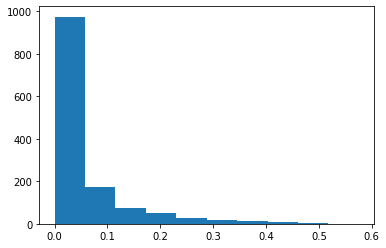

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(rich_zips['RICH_INDEX'].values);

In [37]:
# identify zip codes with the highest portion of rich households
%matplotlib inline
import matplotlib.pyplot as plt

rich_zips.sort_values(by='RICH_INDEX',ascending=False).head(20)

INCGROUP,ZIP,"$200,000 or more",Total,RICH_INDEX
45,10282.0,1370.0,2380.0,0.575630
7,10007.0,1790.0,3760.0,0.476064
93,10514.0,2560.0,5440.0,0.470588
137,10597.0,220.0,480.0,0.458333
43,10162.0,330.0,730.0,0.452055
40,10069.0,1430.0,3170.0,0.451104
85,10504.0,1740.0,4170.0,0.417266
109,10538.0,3310.0,8120.0,0.407635
215,11030.0,3560.0,8750.0,0.406857
333,11568.0,680.0,1680.0,0.404762


## Investigate distribution of rich

In [69]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score


In [70]:
df_train = merge_loc[~merge_loc['RICH_INDEX'].isna()].groupby(['LAT','LON','RICH_INDEX']).size().reset_index().drop(columns=0)

x_train = df_train[['LAT','LON']]
y_train = df_train['RICH_INDEX']

In [71]:
df_test = merge_loc[merge_loc['RICH_INDEX'].isna()].groupby(['LAT','LON']).size().reset_index().drop(columns=0)

x_test = df_test[['LAT','LON']]


In [72]:
reg = linear_model.LinearRegression()

reg.fit(x_train,y_train)

y_hat = reg.predict(x_train)

#### Conclude that R^2 is too low to predict income levels accurately

In [73]:
# The coefficients
print('Coefficients: \n', reg.coef_)
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y_train,y_hat))
# R^2
print('Coefficient of determination: %.2f' % r2_score(y_train,y_hat))

Coefficients: 
 [-0.73445891 -1.00976909]
Mean squared error: 0.01
Coefficient of determination: 0.40
